In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install timm


In [4]:
# Define data directories
train_dir = '/kaggle/input/chest-ctscan-images/Data/train'
valid_dir = '/kaggle/input/chest-ctscan-images/Data/valid'
test_dir = '/kaggle/input/chest-ctscan-images/Data/test'

In [5]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [7]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [8]:
# Load Swin Transformer model
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=4)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [9]:
# Training settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [10]:
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
# Tracking metrics
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

In [12]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(total_correct / total_samples)

    # Validation loop
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    valid_losses.append(total_loss / len(valid_loader))
    valid_accuracies.append(total_correct / total_samples)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Valid Acc: {valid_accuracies[-1]:.4f}")

Epoch [1/50], Train Loss: 1.1019, Valid Loss: 0.9715, Train Acc: 0.4470, Valid Acc: 0.5417
Epoch [2/50], Train Loss: 0.7489, Valid Loss: 0.6544, Train Acc: 0.6378, Valid Acc: 0.6111
Epoch [7/50], Train Loss: 0.1961, Valid Loss: 0.2884, Train Acc: 0.9380, Valid Acc: 0.9028
Epoch [8/50], Train Loss: 0.1596, Valid Loss: 0.3127, Train Acc: 0.9380, Valid Acc: 0.9028
Epoch [9/50], Train Loss: 0.1653, Valid Loss: 0.5651, Train Acc: 0.9494, Valid Acc: 0.8194
Epoch [12/50], Train Loss: 0.0058, Valid Loss: 0.5787, Train Acc: 0.9967, Valid Acc: 0.8611
Epoch [13/50], Train Loss: 0.0030, Valid Loss: 0.6448, Train Acc: 0.9984, Valid Acc: 0.8611
Epoch [14/50], Train Loss: 0.0048, Valid Loss: 0.7999, Train Acc: 0.9984, Valid Acc: 0.8194
Epoch [15/50], Train Loss: 0.0034, Valid Loss: 0.8307, Train Acc: 0.9967, Valid Acc: 0.8333
Epoch [16/50], Train Loss: 0.0033, Valid Loss: 0.6733, Train Acc: 0.9967, Valid Acc: 0.8611
Epoch [17/50], Train Loss: 0.0034, Valid Loss: 0.6712, Train Acc: 0.9967, Valid Acc: 

In [13]:
# Save the model
model_save_path = 'swin_transformer_model.pth'
torch.save(model.state_dict(), model_save_path)

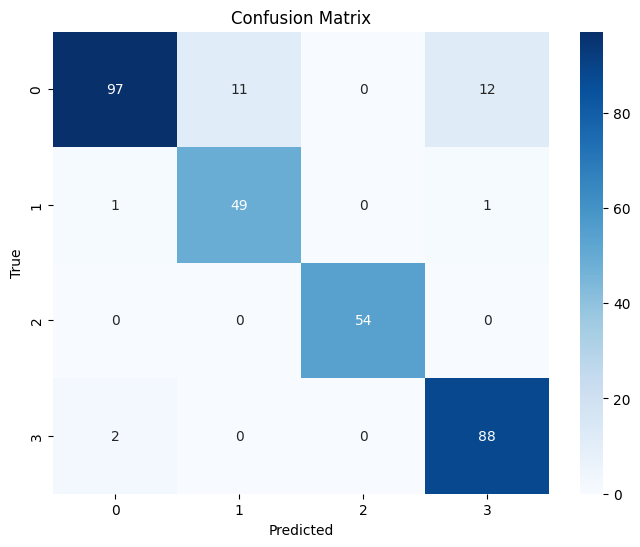

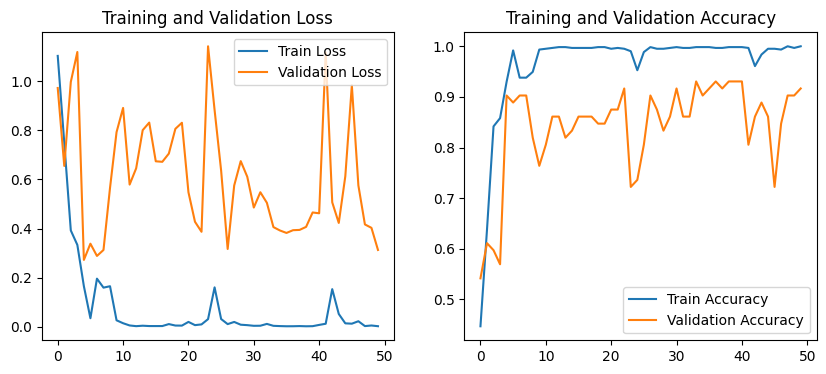

Training complete. Model saved to swin_transformer_model.pth


In [14]:
# Test loop and metrics calculation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate metrics and plot confusion matrix
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusionMetrix.png')
plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('accuracyLoss.png')
plt.show()

print("Training complete. Model saved to", model_save_path)